# Titanic 生存预测

Titanic 生存模型预测，其中包含了两组数据：train.csv 和 test.csv，分别为训练集合和测试集合。

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

观察前几行的源数据:

In [2]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
sns.set_style('whitegrid')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


数据信息总览：

In [3]:
train_data.info()
print("-" * 40)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

从上面我们可以看出，Age、Cabin、Embarked、Fare几个特征存在缺失值。

绘制存活的比例：

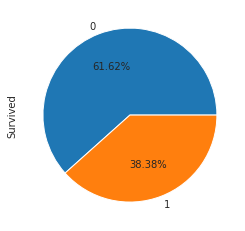

In [4]:
train_data['Survived'].value_counts().plot.pie(autopct='%1.2f%%')

## 2. 缺失值处理的方法

对数据进行分析的时候要注意其中是否有缺失值。

一些机器学习算法能够处理缺失值，比如神经网络，一些则不能。对于缺失值，一般有以下几种处理方法：

1. 如果数据集很多，但有很少的缺失值，可以删掉带缺失值的行；
2. 如果该属性相对学习来说不是很重要，可以对缺失值赋均值或者众数。比如在哪儿上船Embarked这一属性（共有三个上船地点），缺失俩值，可以用众数赋值

In [5]:
train_data.Embarked[train_data.Embarked.isnull()] = train_data.Embarked.dropna().mode().values

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


3. 对于标称属性，可以赋一个代表缺失的值，比如‘U0’。因为缺失本身也可能代表着一些隐含信息。比如船舱号Cabin这一属性，缺失可能代表并没有船舱。

In [7]:
#replace missing value with U0
train_data['Cabin'] = train_data.Cabin.fillna('U0') # train_data.Cabin[train_data.Cabin.isnull()]='U0'

4. 使用回归随机森林等模型来预测缺失属性的值。因为Age在该数据集里是一个相当重要的特征（先对Age进行分析即可得知），所以保证一定的缺失值填充准确率是非常重要的，对结果也会产生较大影响。一般情况下，会使用数据完整的条目作为模型的训练集，以此来预测缺失值。对于当前的这个数据，可以使用随机森林来预测也可以使用线性回归预测。这里使用随机森林预测模型，选取数据集中的数值属性作为特征（因为sklearn的模型只能处理数值属性，所以这里先仅选取数值特征，但在实际的应用中需要将非数值特征转换为数值特征）

In [8]:
from sklearn.ensemble import RandomForestRegressor

#choose training data to predict age
age_df = train_data[['Age','Survived','Fare','Parch','SibSp','Pclass']]
age_df_notnull = age_df.loc[(train_data['Age'].notnull())]
age_df_isnull = age_df.loc[(train_data['Age'].isnull())]
X=age_df_notnull.values[:,1:]
Y=age_df_notnull.values[:,0]
# use RandomForestRegression to train data
RFR = RandomForestRegressor(n_estimators=1000,n_jobs=-1)
RFR.fit(X,Y)
predictAges = RFR.predict(age_df_isnull.values[:,1:])
train_data.loc[train_data['Age'].isnull(),['Age']] = predictAges

让我们再来看一下缺失数据处理后的DataFram：

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## 3. 分析数据关系

### 1.性别与是否生存的关系 Sex

In [10]:
train_data.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

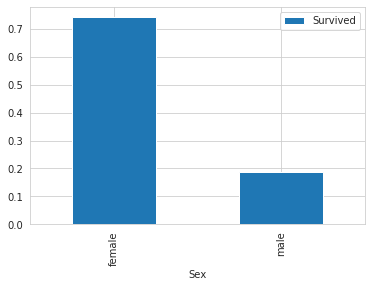

In [11]:
train_data[['Sex','Survived']].groupby(['Sex']).mean().plot.bar()

以上为不同性别的生存率，可见在泰坦尼克号事故中，还是体现了Lady First。

### 2.船舱等级和生存与否的关系 Pclass

In [12]:
train_data.groupby(['Pclass','Survived'])['Pclass'].count()

Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
Name: Pclass, dtype: int64

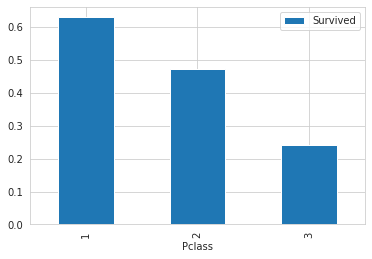

In [13]:
train_data[['Pclass','Survived']].groupby('Pclass').mean().plot.bar()

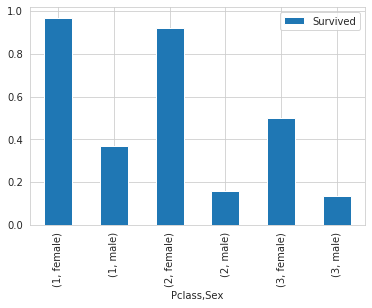

In [14]:
train_data[['Pclass','Sex','Survived']].groupby(['Pclass','Sex']).mean().plot.bar()

不同等级船舱的男女生存率：

In [15]:
train_data.groupby(['Pclass','Sex','Survived'])['Survived'].count()

Pclass  Sex     Survived
1       female  0             3
                1            91
        male    0            77
                1            45
2       female  0             6
                1            70
        male    0            91
                1            17
3       female  0            72
                1            72
        male    0           300
                1            47
Name: Survived, dtype: int64

从图和表中可以看出，总体上泰坦尼克号逃生是妇女优先，但是对于不同等级的船舱还是有一定的区别。

### 3. 年龄与存活与否的关系 Age

分别分析不同等级船舱和不同性别下的年龄分布和生存的关系：

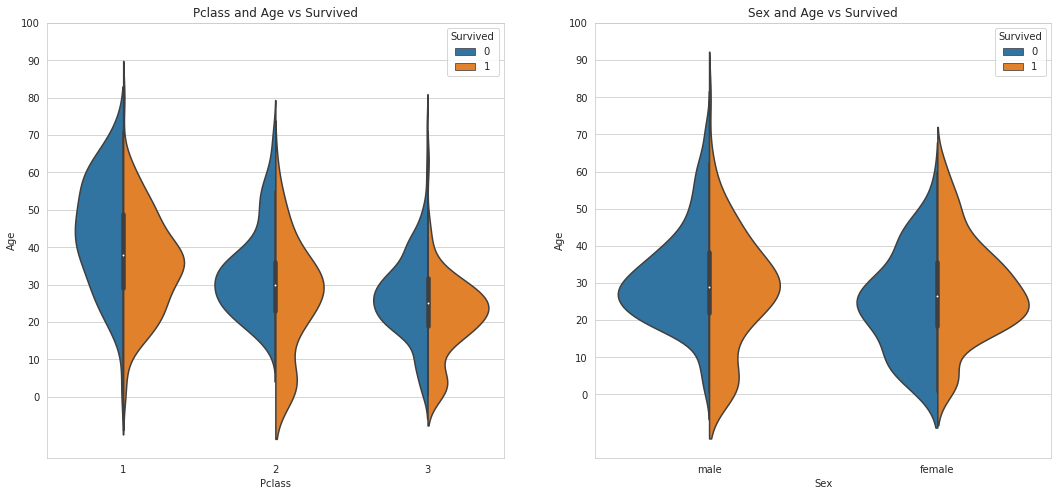

In [16]:
fig, ax = plt.subplots(1,2,figsize=(18,8))
sns.violinplot('Pclass','Age',hue='Survived',data=train_data,split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))
sns.violinplot('Sex','Age',hue='Survived',data=train_data,split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))
plt.show()

分析总体的年龄分布：

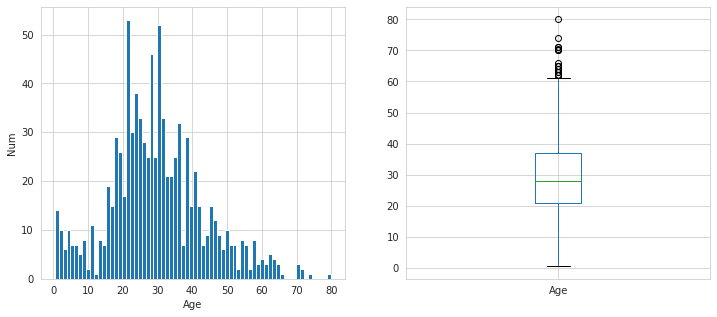

In [17]:
plt.figure(figsize=(12,5))

plt.subplot(121)
train_data['Age'].hist(bins=70)
plt.xlabel('Age')
plt.ylabel('Num')

plt.subplot(122)
train_data.boxplot(column='Age',showfliers=True)

plt.show()

不同年龄下的生存和非生存的分布情况：

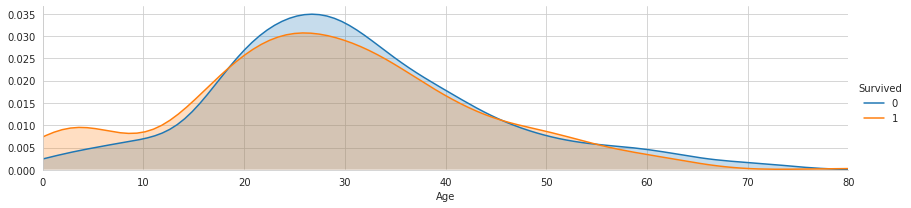

In [18]:
facet = sns.FacetGrid(train_data, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train_data['Age'].max()))
facet.add_legend()

不同年龄下的平均生存率：

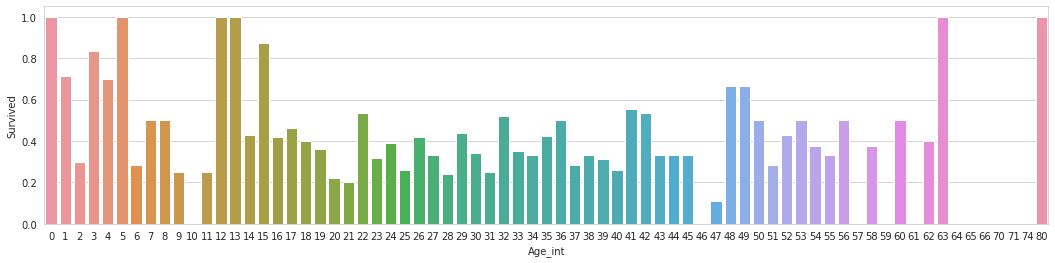

In [19]:
# average survived passengers by age
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
train_data["Age_int"] = train_data["Age"].astype(int)
average_age = train_data[["Age_int", "Survived"]].groupby(['Age_int'],as_index=False).mean()
sns.barplot(x='Age_int', y='Survived', data=average_age)

In [20]:
train_data['Age'].describe()

count    891.000000
mean      29.661829
std       13.735114
min        0.420000
25%       21.000000
50%       28.000000
75%       37.000000
max       80.000000
Name: Age, dtype: float64

样本有891，平均年龄约为30岁，标准差13.5岁，最小年龄为0.42，最大年龄80.
按照年龄，将乘客划分为儿童、少年、成年和老年，分析四个群体的生还情况：

In [21]:
bins = [0,12,18,65,100]
train_data['Age_group'] = pd.cut(train_data['Age'],bins)
by_age = train_data.groupby('Age_group')['Survived'].mean()
by_age

Age_group
(0, 12]      0.506173
(12, 18]     0.466667
(18, 65]     0.364512
(65, 100]    0.125000
Name: Survived, dtype: float64

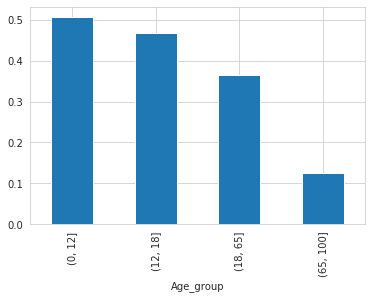

In [22]:
by_age.plot(kind = 'bar')

### 4 称呼与存活与否的关系 Name

通过观察名字数据，我们可以看出其中包括对乘客的称呼，如：Mr、Miss、Mrs等，称呼信息包含了乘客的年龄、性别，同时也包含了如社会地位等的称呼，如：Dr,、Lady、Major、Master等的称呼。

In [23]:
train_data['Title'] = train_data['Name'].str.extract('([A-Za-z]+)\.',expand=False)
pd.crosstab(train_data['Title'],train_data['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


观察不同称呼与生存率的关系：

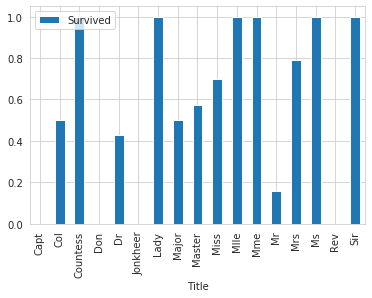

In [24]:
train_data[['Title','Survived']].groupby(['Title']).mean().plot.bar()

同时，对于名字，我们还可以观察名字长度和生存率之间存在关系的可能：

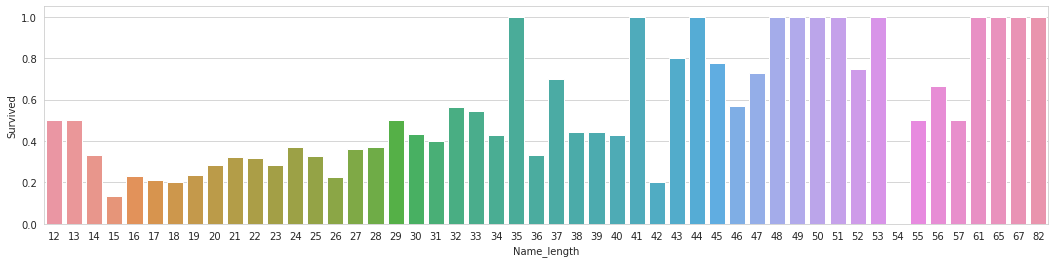

In [25]:
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
train_data['Name_length'] = train_data['Name'].apply(len)
name_length = train_data[['Name_length','Survived']].groupby(['Name_length'],as_index=False).mean()
sns.barplot(x='Name_length', y='Survived', data=name_length)

从上面的图片可以看出，名字长度和生存与否确实也存在一定的相关性。

### 5. 有无兄弟姐妹和存活与否的关系 SibSp

In [26]:
# 将数据分为有兄弟姐妹的和没有兄弟姐妹的两组：
sibsp_df = train_data[train_data['SibSp'] != 0]
no_sibsp_df = train_data[train_data['SibSp'] == 0]

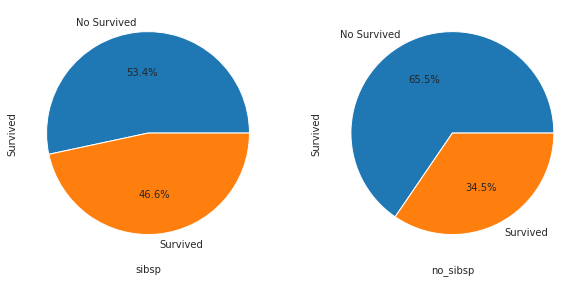

In [27]:
plt.figure(figsize=(10,5))
plt.subplot(121)
sibsp_df['Survived'].value_counts().plot.pie(labels=['No Survived', 'Survived'], autopct = '%1.1f%%')
plt.xlabel('sibsp')

plt.subplot(122)
no_sibsp_df['Survived'].value_counts().plot.pie(labels=['No Survived', 'Survived'],autopct = '%1.1f%%')
plt.xlabel('no_sibsp')
plt.show()

### 6. 有无父母子女和存活与否的关系 Parch

和有无兄弟姐妹一样，同样分析可以得到：

In [28]:
parch_df = train_data[train_data['Parch'] != 0]
no_parch_df = train_data[train_data['Parch'] == 0]

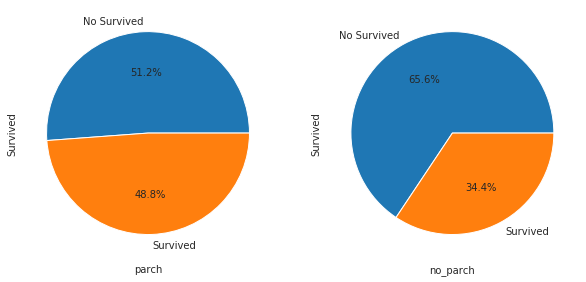

In [29]:
plt.figure(figsize=(10,5))
plt.subplot(121)
parch_df['Survived'].value_counts().plot.pie(labels=['No Survived','Survived'],autopct = '%1.1f%%')
plt.xlabel('parch')

plt.subplot(122)
no_parch_df['Survived'].value_counts().plot.pie(labels=['No Survived', 'Survived'],autopct='%1.1f%%')
plt.xlabel('no_parch')

plt.show()

### 7. 亲友的人数和存活与否的关系 SibSp & Parch

Text(0.5, 1.0, 'SibSp and Survived')

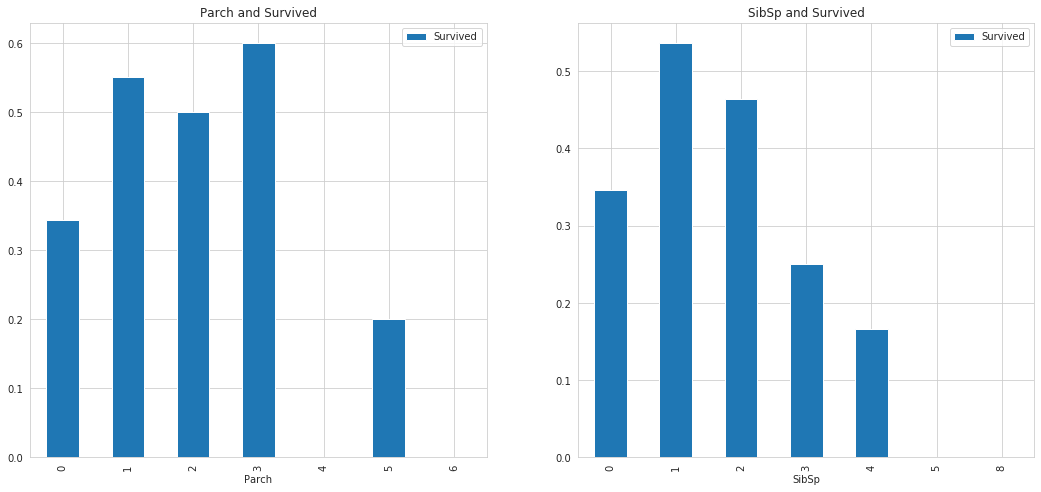

In [30]:
fig, ax = plt.subplots(1,2,figsize=(18,8))
train_data[['Parch','Survived']].groupby(['Parch']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Parch and Survived')
train_data[['SibSp','Survived']].groupby(['SibSp']).mean().plot.bar(ax=ax[1])
ax[1].set_title('SibSp and Survived')

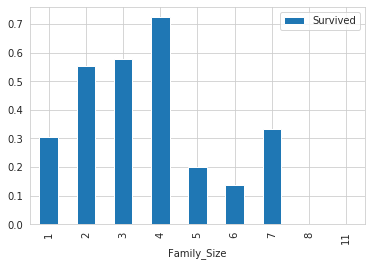

In [31]:
train_data['Family_Size'] = train_data['Parch'] + train_data['SibSp'] + 1
train_data[['Family_Size','Survived']].groupby(['Family_Size']).mean().plot.bar()

从图表中可以看出，若独自一人，那么其存活率比较低；但是如果亲友太多的话，存活率也会很低。

### 8. 票价分布和存活与否的关系 Fare

首先绘制票价的分布情况：

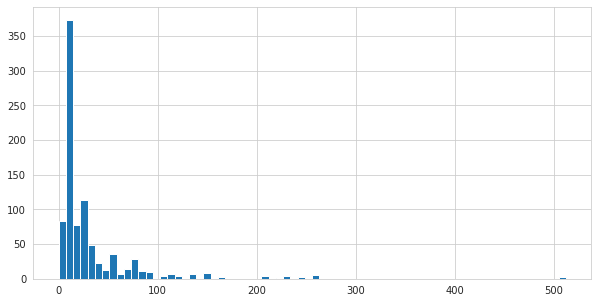

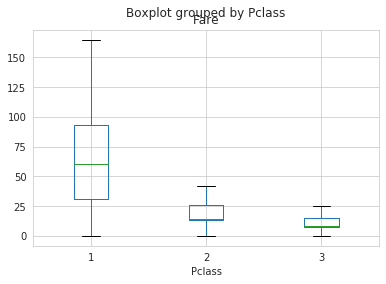

In [32]:
plt.figure(figsize=(10,5))
train_data['Fare'].hist(bins=70)
train_data.boxplot(column='Fare',by='Pclass',showfliers=False)
plt.show()

In [33]:
train_data['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

绘制生存与否与票价均值和方差的关系：

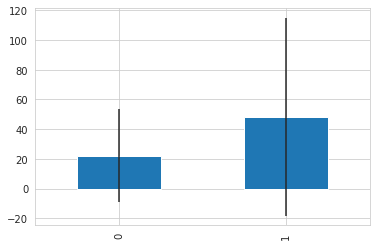

In [34]:
fare_not_survived = train_data['Fare'][train_data['Survived'] == 0]
fare_survived = train_data['Fare'][train_data['Survived'] == 1]
average_fare = pd.DataFrame([fare_not_survived.mean(),fare_survived.mean()])
std_fare = pd.DataFrame([fare_not_survived.std(),fare_survived.std()])
#average_fare.plot(yerr=std_fare,kind='bar',legend=False)
average_fare.plot(kind='bar',legend=False,yerr=std_fare)
plt.show()

由上图标可知，票价与是否生还有一定的相关性，生还者的平均票价要大于未生还者的平均票价。

### 9. 船舱类型和存活与否的关系 Cabin

由于船舱的缺失值确实太多，有效值仅仅有204个，很难分析出不同的船舱和存活的关系，所以在做特征工程的时候，可以直接将该组特征丢弃。

当然，这里我们也可以对其进行一下分析，对于缺失的数据都分为一类。

简单地将数据分为是否有Cabin记录作为特征，与生存与否进行分析：

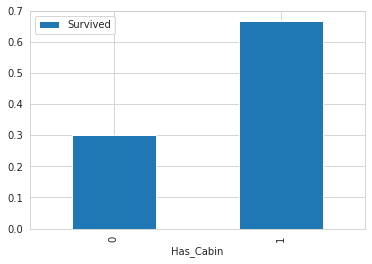

In [35]:
# Replace missing values with "U0"
train_data.loc[train_data.Cabin.isnull(),'Cabin'] = 'U0'
train_data['Has_Cabin'] = train_data['Cabin'].apply(lambda x: 0 if x=='U0' else 1)
train_data[['Has_Cabin','Survived']].groupby(['Has_Cabin']).mean().plot.bar()

对不同类型的船舱进行分析：

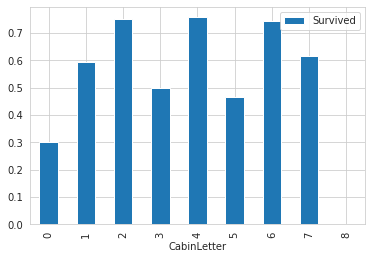

In [36]:
# create feature for the alphabetical part of the cabin number
train_data['CabinLetter'] = train_data['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
# convert the distinct cabin letters with incremental integer values
train_data['CabinLetter'] = pd.factorize(train_data['CabinLetter'])[0]
train_data[['CabinLetter','Survived']].groupby(['CabinLetter']).mean().plot.bar()

可见，不同的船舱生存率也有不同，但是差别不大。所以在处理中，我们可以直接将特征删除。

### 10. 港口和存活与否的关系 Embarked

泰坦尼克号从英国的南安普顿港出发，途径法国瑟堡和爱尔兰昆士敦，那么在昆士敦之前上船的人，有可能在瑟堡或昆士敦下船，这些人将不会遇到海难。

Text(0.5, 1.0, 'Embarked and Survived')

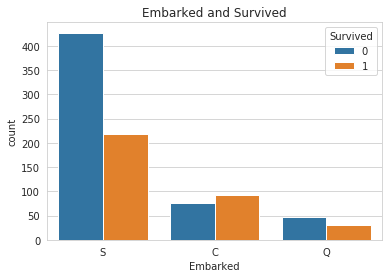

In [37]:
sns.countplot('Embarked',hue='Survived',data=train_data)
plt.title('Embarked and Survived')

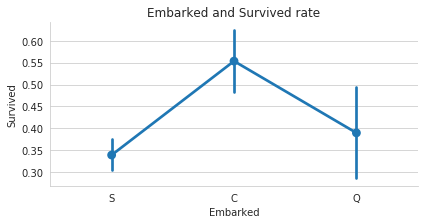

In [38]:
sns.factorplot('Embarked','Survived',data=train_data,size=3,aspect=2)
plt.title('Embarked and Survived rate')
plt.show()

由上可以看出，在不同的港口上船，生还率不同，C最高，Q次之，S最低。

以上为所给出的数据特征与生还与否的分析。

据了解，泰坦尼克号上共有2224名乘客。本训练数据只给出了891名乘客的信息，如果该数据集是从总共的2224人中随机选出的，根据中心极限定理，该样本的数据也足够大，那么我们的分析结果就具有代表性；但如果不是随机选取，那么我们的分析结果就可能不太靠谱了。

### 11. 其他可能和存活与否有关系的特征

对于数据集中没有给出的特征信息，我们还可以联想其他可能会对模型产生影响的特征因素。如：乘客的国籍、乘客的身高、乘客的体重、乘客是否会游泳、乘客职业等等。

另外还有数据集中没有分析的几个特征：Ticket（船票号）、Cabin（船舱号）,这些因素的不同可能会影响乘客在船中的位置从而影响逃生的顺序。但是船舱号数据缺失，船票号类别大，难以分析规律，所以在后期模型融合的时候，将这些因素交由模型来决定其重要性。

## 4. 变量转换


变量转换的目的是将数据转换为适用于模型使用的数据，不同模型接受不同类型的数据，Scikit-learn要求数据都是数字型numeric，所以我们要将一些非数字型的原始数据转换为数字型numeric。

所以下面对数据的转换进行介绍，以在进行特征工程的时候使用。

所有的数据可以分为两类：

1. 定性(Quantitative)变量可以以某种方式排序，Age就是一个很好的列子。
2. 定量(Qualitative)变量描述了物体的某一（不能被数学表示的）方面，Embarked就是一个例子。

### 4.1 定性(Qualitative)转换：

#### 4.1.1. Dummy Variables

就是类别变量或者二元变量，当qualitative variable是一些频繁出现的几个独立变量时，Dummy Variables比较适合使用。我们以Embarked为例，Embarked只包含三个值'S','C','Q'，我们可以使用下面的代码将其转换为dummies:

In [39]:
embark_dummies = pd.get_dummies(train_data['Embarked'])
train_data = train_data.join(embark_dummies)
train_data.drop(['Embarked'], axis = 1, inplace=True)

In [40]:
embark_dummies = train_data[['S', 'C', 'Q']]
embark_dummies.head()

,S,C,Q
0,1,0,0
1,0,1,0
2,1,0,0
3,1,0,0
4,1,0,0


#### 4.1.2 Factorizing

dummy不好处理Cabin（船舱号）这种标称属性，因为他出现的变量比较多。所以Pandas有一个方法叫做factorize()，它可以创建一些数字，来表示类别变量，对每一个类别映射一个ID，这种映射最后只生成一个特征，不像dummy那样生成多个特征。

In [41]:
# Replace missing values with "U0"
train_data['Cabin'][train_data.Cabin.isnull()] = 'U0'
# create feature for the alphabetical part of the cabin number
train_data['CabinLetter'] = train_data['Cabin'].map(lambda x : re.compile("([a-zA-Z]+)").search(x).group)
train_data['CabinLetter'] = pd.factorize(train_data['CabinLetter'])[0]
# convert the distinct cabin letters with incremental integer values    
train_data['CabinLetter'].head()

0    0
1    1
2    2
3    3
4    4
Name: CabinLetter, dtype: int64

## 4.2 定量(Quantitative)转换：

#### 4.2.1 Scaling

Scaling可以将一个很大范围的数值映射到一个很小的范围(通常是-1 - 1，或则是0 - 1)，很多情况下我们需要将数值做Scaling使其范围大小一样，否则大范围数值特征将会由更高的权重。比如：Age的范围可能只是0-100，而income的范围可能是0-10000000，在某些对数组大小敏感的模型中会影响其结果。

下面对Age进行Scaling：

In [42]:
from sklearn import preprocessing

assert np.size(train_data['Age']) == 891
# StandardScaler will subtract the mean from each value then scale to the unit variance
scaler = preprocessing.StandardScaler()
train_data['Age_scaled'] = scaler.fit_transform(train_data['Age'].values.reshape(-1,1))
train_data['Age_scaled'].mean()

-1.8896220166599886e-16

#### 4.2.2 Binning

Binning通过观察“邻居”(即周围的值)将连续数据离散化。存储的值被分布到一些“桶”或“箱“”中，就像直方图的bin将数据划分成几块一样。下面的代码对Fare进行Binning。

In [43]:
# Divide all fares into quartiles
train_data['Fare_bin'] = pd.qcut(train_data['Fare'], 5)
train_data['Fare_bin'].head()

0      (-0.001, 7.854]
1    (39.688, 512.329]
2        (7.854, 10.5]
3    (39.688, 512.329]
4        (7.854, 10.5]
Name: Fare_bin, dtype: category
Categories (5, interval[float64]): [(-0.001, 7.854] < (7.854, 10.5] < (10.5, 21.679] < (21.679, 39.688] < (39.688, 512.329]]

在将数据Bining化后，要么将数据factorize化，要么dummies化。

In [44]:
# qcut() creates a new variable that identifies the quartile range, but we can't use the string
# so either factorize or create dummies from the result

# factorize
train_data['Fare_bin_id'] = pd.factorize(train_data['Fare_bin'])[0]

# dummies
fare_bin_dummies_df = pd.get_dummies(train_data['Fare_bin']).rename(columns=lambda x: 'Fare_' + str(x))
train_data = pd.concat([train_data, fare_bin_dummies_df],axis=1)

## 5. 特征工程

在进行特征工程的时候，我们不仅需要对训练数据进行处理，还需要同时将测试数据同训练数据一起处理，使得二者具有相同的数据类型和数据分布。

In [45]:
train_df_org = pd.read_csv('data/train.csv')
test_df_org = pd.read_csv('data/test.csv')
test_df_org['Survived'] = 0

combined_train_test =train_df_org.append(test_df_org)
PassengerId = test_df_org['PassengerId']

对数据进行特征工程，也就是从各项参数中提取出对输出结果有或大或小的影响的特征，将这些特征作为训练模型的依据。

一般来说，我们会先从含有缺失值的特征开始。

### 5.1 Embarked

因为“Embarked”项的缺失值不多，所以这里我们以众数来填充：

In [46]:
combined_train_test['Embarked'].fillna(combined_train_test['Embarked'].mode().iloc[0],inplace=True)

对于三种不同的港口，由上面介绍的数值转换，我们知道可以有两种特征处理方式：dummy和facrorizing。因为只有三个港口，所以我们可以直接用dummy来处理：

In [47]:
# 为了后面的特征分析，这里我们将 Embarked 特征进行facrorizing
combined_train_test['Embarked'] = pd.factorize(combined_train_test['Embarked'])[0]

In [48]:
# 使用 pd.get_dummies 获取one-hot 编码
emb_dummies_df = pd.get_dummies(combined_train_test['Embarked'],prefix = combined_train_test[['Embarked']].columns[0])
combined_train_test = pd.concat([combined_train_test,emb_dummies_df],axis=1)

### 5.2 Sex

In [49]:
# 为了后面的特征分析，这里我们也将 Sex 特征进行facrorizing
combined_train_test['Sex'] = pd.factorize(combined_train_test['Sex'])[0]

In [50]:
sex_dummies_df = pd.get_dummies(combined_train_test['Sex'],prefix = combined_train_test[['Sex']].columns[0])
combined_train_test = pd.concat([combined_train_test,sex_dummies_df],axis=1)

### 5.3 Name

首先先从名字中提取各种称呼：

In [51]:
# what is each person's title
combined_train_test['Title'] = combined_train_test['Name'].map(lambda x: re.compile(", (.*?)\.").findall(x)[0])

将各式称呼进行统一化处理：

In [52]:
title_Dict = {}
title_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
title_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
title_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
title_Dict.update(dict.fromkeys(['Master','Jonkheer'], 'Master'))

combined_train_test['Title'] = combined_train_test['Title'].map(title_Dict)

使用dummy对不同的称呼进行分列：

In [53]:
# 为了后面的特征分析，这里我们也将 Title 特征进行facrorizing
combined_train_test['Title'] = pd.factorize(combined_train_test['Title'])[0]

In [54]:
title_dummies_df = pd.get_dummies(combined_train_test['Title'], prefix=combined_train_test[['Title']].columns[0])
combined_train_test = pd.concat([combined_train_test,title_dummies_df],axis=1)

增加名字长度的特征：

In [55]:
title_dummies_df = pd.get_dummies(combined_train_test['Title'], prefix=combined_train_test[['Title']].columns[0])
combined_train_test = pd.concat([combined_train_test, title_dummies_df], axis=1)

combined_train_test['Name_length'] = combined_train_test['Name'].apply(len)

### 5.4 Fare

由前面分析可以知道，Fare项在测试数据中缺少一个值，所以需要对该值进行填充。

我们按照一二三等舱各自的均价来填充：

下面transform将函数np.mean应用到各个group中。

In [56]:
combined_train_test['Fare'] = combined_train_test[['Fare']].fillna(combined_train_test.groupby('Pclass').transform(np.mean))

通过对Ticket数据的分析，我们可以看到部分票号数据有重复，同时结合亲属人数及名字的数据，和票价船舱等级对比，我们可以知道购买的票中有家庭票和团体票，所以我们需要将团体票的票价分配到每个人的头上。

In [57]:
combined_train_test['Group_Ticket'] = combined_train_test['Fare'].groupby(by=combined_train_test['Ticket']).transform('count')
combined_train_test['Fare'] = combined_train_test['Fare'] / combined_train_test['Group_Ticket']
combined_train_test.drop(['Group_Ticket'], axis=1, inplace=True)

In [58]:
combined_train_test['Fare_bin'] = pd.qcut(combined_train_test['Fare'], 5)

对于5个等级的票价我们也可以继续使用dummy为票价等级分列：

In [59]:
combined_train_test['Fare_bin_id'] = pd.factorize(combined_train_test['Fare_bin'])[0]

In [60]:
fare_bin_dummies_df = pd.get_dummies(combined_train_test['Fare_bin_id']).rename(columns=lambda x: 'Fare_' + str(x))
combined_train_test = pd.concat([combined_train_test, fare_bin_dummies_df], axis=1)
combined_train_test.drop(['Fare_bin'], axis=1, inplace=True)

In [61]:
combined_train_test.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Title_3,Title_4,Title_5,Name_length,Fare_bin_id,Fare_0,Fare_1,Fare_2,Fare_3,Fare_4
0,22.0,NaN,0,7.25000,"Braund, Mr. Owen Harris",0,1,3,0,1,...,0,0,0,23,0,1,0,0,0,0
1,38.0,C85,1,35.64165,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,...,0,0,0,51,1,0,1,0,0,0
2,26.0,NaN,0,7.92500,"Heikkinen, Miss. Laina",0,3,3,1,0,...,0,0,0,22,2,0,0,1,0,0
3,35.0,C123,0,26.55000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,...,0,0,0,44,1,0,1,0,0,0
4,35.0,NaN,0,8.05000,"Allen, Mr. William Henry",0,5,3,0,0,...,0,0,0,24,2,0,0,1,0,0


### 5.5 Pclass

Pclass这一项，其实已经可以不用继续处理了，我们只需要将其转换为dummy形式即可。

但是为了更好的分析问题，我们这里假设对于不同等级的船舱，各船舱内部的票价也说明了各等级舱的位置，那么也就很有可能与逃生的顺序有关系。所以这里分出每等舱里的高价和低价位。

In [62]:
from sklearn.preprocessing import LabelEncoder

# 建立Pclass fare Category
def pclass_fare_category(df,pclass1_mean_fare,pclass2_mean_fare,pclass3_mean_fare):
    if df['Pclass'] == 1:
        if df['Fare'] <= pclass1_mean_fare:
            return 'Pclass1_Low'
        else:
            return 'Pclass1_High'
    elif df['Pclass'] == 2:
        if df['Fare'] <= pclass2_mean_fare:
            return 'Pclass2_Low'
        else:
            return 'Pclass2_High'
    elif df['Pclass'] == 3:
        if df['Fare'] <= pclass3_mean_fare:
            return 'Pclass3_Low'
        else:
            return 'Pclass3_High'

In [63]:
Pclass1_mean_fare = combined_train_test['Fare'].groupby(by=combined_train_test['Pclass']).mean().get([1]).values[0]
Pclass2_mean_fare = combined_train_test['Fare'].groupby(by=combined_train_test['Pclass']).mean().get([2]).values[0]
Pclass3_mean_fare = combined_train_test['Fare'].groupby(by=combined_train_test['Pclass']).mean().get([3]).values[0]

In [64]:
args_pclass = (Pclass1_mean_fare,Pclass2_mean_fare,Pclass3_mean_fare)

In [65]:
combined_train_test['Pclass_Fare_Category'] = combined_train_test.apply(pclass_fare_category
                                                                        , args = args_pclass
                                                                        , axis =1)
pclass_level=LabelEncoder()

In [66]:
combined_train_test.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Title_4,Title_5,Name_length,Fare_bin_id,Fare_0,Fare_1,Fare_2,Fare_3,Fare_4,Pclass_Fare_Category
0,22.0,NaN,0,7.25000,"Braund, Mr. Owen Harris",0,1,3,0,1,...,0,0,23,0,1,0,0,0,0,Pclass3_Low
1,38.0,C85,1,35.64165,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,...,0,0,51,1,0,1,0,0,0,Pclass1_High
2,26.0,NaN,0,7.92500,"Heikkinen, Miss. Laina",0,3,3,1,0,...,0,0,22,2,0,0,1,0,0,Pclass3_High
3,35.0,C123,0,26.55000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,...,0,0,44,1,0,1,0,0,0,Pclass1_Low
4,35.0,NaN,0,8.05000,"Allen, Mr. William Henry",0,5,3,0,0,...,0,0,24,2,0,0,1,0,0,Pclass3_High


In [67]:
pclass_level.fit(np.array(['Pclass1_Low','Pclass1_High','Pclass2_Low','Pclass2_High','Pclass3_Low','Pclass3_High']))

LabelEncoder()

In [68]:
combined_train_test['Pclass_Fare_Category'] = pclass_level.transform(combined_train_test['Pclass_Fare_Category'])

In [69]:
# dummy 转换
pclass_dummies_df = pd.get_dummies(combined_train_test['Pclass_Fare_Category']).rename(columns=lambda x : 'Pclass_' + str(x))
combined_train_test = pd.concat([combined_train_test, pclass_dummies_df],axis=1)

#同时，我们将 Pclass 特征factorize化：
combined_train_test['Pclass'] = pd.factorize(combined_train_test['Pclass'])[0]

### 5.6 Parch and SibSp

由前面的分析，我们可以知道，亲友的数量没有或者太多会影响到Survived。所以将二者合并为FamliySize这一组合项，同时也保留这两项。

In [70]:
def family_size_category(family_size):
    if family_size <= 1:
        return 'Single'
    elif family_size <= 4:
        return 'Small_Family'
    else:
        return 'Large_Family'

In [71]:
combined_train_test['Family_Size'] = combined_train_test['Parch'] + combined_train_test['SibSp'] + 1
combined_train_test['Family_Size_Category'] = combined_train_test['Family_Size'].map(family_size_category)

le_family = LabelEncoder()
le_family.fit(np.array(['Single','Small_Family','Large_Family']))

LabelEncoder()

In [72]:
combined_train_test['Family_Size_Category'] = le_family.transform(combined_train_test['Family_Size_Category'])

In [73]:
family_size_dummies_df = pd.get_dummies(combined_train_test['Family_Size_Category']
                                      , prefix = combined_train_test[['Family_Size_Category']].columns[0])

In [74]:
combined_train_Test = pd.concat([combined_train_test,family_size_dummies_df],axis=1)

### 5.7 Age

因为Age项的缺失值较多，所以不能直接填充age的众数或者平均数。

常见的有两种对年龄的填充方式：一种是根据Title中的称呼，如Mr，Master、Miss等称呼不同类别的人的平均年龄来填充；一种是综合几项如Sex、Title、Pclass等其他没有缺失值的项，使用机器学习算法来预测Age。

这里我们使用后者来处理。以Age为目标值，将Age完整的项作为训练集，将Age缺失的项作为测试集。

In [75]:
missing_age_df = pd.DataFrame(combined_train_test[
 ['Age', 'Embarked', 'Sex', 'Title', 'Name_length', 'Family_Size', 'Family_Size_Category','Fare', 'Fare_bin_id', 'Pclass']
])

missing_age_train = missing_age_df[missing_age_df['Age'].notnull()]
missing_age_test = missing_age_df[missing_age_df['Age'].isnull()]

In [76]:
missing_age_test.head()

,Age,Embarked,Sex,Title,Name_length,Family_Size,Family_Size_Category,Fare,Fare_bin_id,Pclass
5,NaN,2,0,0,16,1,1,8.4583,2,0
17,NaN,0,0,0,28,1,1,13.0000,3,2
19,NaN,1,1,1,23,1,1,7.2250,4,0
26,NaN,1,0,0,23,1,1,7.2250,4,0
28,NaN,2,1,2,29,1,1,7.8792,0,0


建立Age的预测模型，我们可以多模型预测，然后再做模型的融合，提高预测的精度。

In [77]:
from sklearn import ensemble
from sklearn import model_selection
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

def fill_missing_age(missing_age_train,missing_age_test):
    missing_age_X_train = missing_age_train.drop(['Age'],axis=1)
    missing_age_y_train = missing_age_train['Age']
    missing_age_X_test = missing_age_test.drop(['Age'],axis=1)

    gbm_reg = GradientBoostingRegressor()
    gbm_reg_param_grid = {
        'n_estimators':[2000]
        ,'max_depth':[4]
        ,'learning_rate':[0.01]
        ,'max_features':[3]
    }
    gbm_reg_grid = model_selection.GridSearchCV(gbm_reg,gbm_reg_param_grid,cv=5,n_jobs=25,verbose=1
                                                ,scoring='neg_mean_squared_error'
                                               )
    gbm_reg_grid.fit(missing_age_X_train,missing_age_y_train)
    
    print('Age feature Best GB Params:' + str(gbm_reg_grid.best_params_))
    print('Age feature Best GB Score:' + str(gbm_reg_grid.best_score_))
    print('GB Train Error for "Age" Feature Regressor:' 
          + str(gbm_reg_grid.score(missing_age_X_train, missing_age_y_train)))
    missing_age_test.loc[:, 'Age_GB'] = gbm_reg_grid.predict(missing_age_X_test)
    print(missing_age_test['Age_GB'][:4])
    # model 2 rf
    rf_reg = RandomForestRegressor()
    rf_reg_param_grid ={
        'n_estimators':[200]
        ,'max_depth':[5]
    }
    rf_reg_grid = model_selection.GridSearchCV(rf_reg
                                              ,rf_reg_param_grid
                                              ,cv = 5
                                              ,n_jobs=50
                                              ,verbose=1
                                              ,scoring='neg_mean_squared_error'
                                              )
    rf_reg_grid.fit(missing_age_X_train,missing_age_y_train)
    print('Age feature Best RF Params:' + str(rf_reg_grid.best_params_))
    print('Age feature Best RF Score:' + str(rf_reg_grid.best_score_))
    print('RF Train Error for "Age" Feature Regressor' 
          + str(rf_reg_grid.score(missing_age_X_train, missing_age_y_train)))
    missing_age_test.loc[:, 'Age_RF'] = rf_reg_grid.predict(missing_age_X_test)
    print(missing_age_test['Age_RF'][:4])

    # two models merge
    print('shape1', missing_age_test['Age'].shape, missing_age_test[['Age_GB', 'Age_RF']].mode(axis=1).shape)
    # missing_age_test['Age'] = missing_age_test[['Age_GB', 'Age_LR']].mode(axis=1)

    missing_age_test.loc[:, 'Age'] = np.mean([missing_age_test['Age_GB'], missing_age_test['Age_RF']])
    print(missing_age_test['Age'][:4])

    missing_age_test.drop(['Age_GB', 'Age_RF'], axis=1, inplace=True)

    return missing_age_test

fill_missing_age(missing_age_train,missing_age_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   5 out of   5 | elapsed:    2.8s finished


Age feature Best GB Params:{'learning_rate': 0.01, 'max_depth': 4, 'max_features': 3, 'n_estimators': 2000}
Age feature Best GB Score:-132.29279945110477
GB Train Error for "Age" Feature Regressor:-64.8675995075329
5     36.031153
17    31.359459
19    34.754148
26    28.672569
Name: Age_GB, dtype: float64
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.1s


Age feature Best RF Params:{'max_depth': 5, 'n_estimators': 200}
Age feature Best RF Score:-118.5342478203329
RF Train Error for "Age" Feature Regressor-96.08522054803612
5     33.471553
17    32.856880
19    34.263744
26    28.024885
Name: Age_RF, dtype: float64
shape1 (263,) (263, 2)
5     29.977469
17    29.977469
19    29.977469
26    29.977469
Name: Age, dtype: float64


[Parallel(n_jobs=50)]: Done   5 out of   5 | elapsed:    1.6s finished


,Age,Embarked,Sex,Title,Name_length,Family_Size,Family_Size_Category,Fare,Fare_bin_id,Pclass
5,29.977469,2,0,0,16,1,1,8.458300,2,0
17,29.977469,0,0,0,28,1,1,13.000000,3,2
19,29.977469,1,1,1,23,1,1,7.225000,4,0
26,29.977469,1,0,0,23,1,1,7.225000,4,0
28,29.977469,2,1,2,29,1,1,7.879200,0,0
29,29.977469,0,0,0,19,1,1,7.895800,0,0
31,29.977469,1,1,1,46,2,2,48.840267,1,1
32,29.977469,2,1,2,24,1,1,7.750000,0,0
36,29.977469,1,0,0,16,1,1,7.229200,4,0
42,29.977469,1,0,0,19,1,1,7.895800,0,0


In [78]:
#利用融合模型预测的结果填充Age的缺失值：
combined_train_test.loc[(combined_train_test.Age.isnull()), 'Age'] = fill_missing_age(missing_age_train, missing_age_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   5 out of   5 | elapsed:    1.7s finished


Age feature Best GB Params:{'learning_rate': 0.01, 'max_depth': 4, 'max_features': 3, 'n_estimators': 2000}
Age feature Best GB Score:-131.6941868922418
GB Train Error for "Age" Feature Regressor:-64.54233635556814
5     36.250890
17    31.366957
19    35.163066
26    29.182122
Name: Age_GB, dtype: float64
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.4s
[Parallel(n_jobs=50)]: Done   5 out of   5 | elapsed:    1.8s finished


Age feature Best RF Params:{'max_depth': 5, 'n_estimators': 200}
Age feature Best RF Score:-118.62106790328372
RF Train Error for "Age" Feature Regressor-95.83274070714802
5     35.013424
17    32.773186
19    34.224699
26    27.853006
Name: Age_RF, dtype: float64
shape1 (263,) (263, 2)
5     30.083906
17    30.083906
19    30.083906
26    30.083906
Name: Age, dtype: float64


### 5.8 Ticket

观察Ticket的值，我们可以看到，Ticket有字母和数字之分，而对于不同的字母，可能在很大程度上就意味着船舱等级或者不同船舱的位置，也会对Survived产生一定的影响，所以我们将Ticket中的字母分开，为数字的部分则分为一类。



In [79]:
combined_train_test['Ticket_letter'] = combined_train_test['Ticket'].str.split().str[0]
combined_train_test['Ticket_letter'] = combined_train_test['Ticket_letter'].apply(lambda x : 'U0' if x.isnumeric() else x)

In [80]:
# 将 Ticket_Letter factorize
combined_train_test['Ticket_letter'] = pd.factorize(combined_train_test['Ticket_letter'])[0]

### 5.9 Cabin

因为Cabin项的缺失值确实太多了，我们很难对其进行分析，或者预测。所以这里我们可以直接将Cabin这一项特征去除。但通过上面的分析，可以知道，该特征信息的有无也与生存率有一定的关系，所以这里我们暂时保留该特征，并将其分为有和无两类。

In [81]:
combined_train_test.loc[combined_train_test.Cabin.isnull(), 'Cabin'] = 'U0'
combined_train_test['Cabin'] = combined_train_test['Cabin'].apply(lambda x: 0 if x == 'U0' else 1)

## 特征间相关性分析

我们挑选一些主要的特征，生成特征之间的关联图，查看特征与特征之间的相关性：

In [82]:
Correlation = pd.DataFrame(combined_train_test[[
    'Embarked'
    , 'Sex'
    , 'Title'
    , 'Name_length'
    , 'Family_Size'
    , 'Family_Size_Category'
    , 'Fare'
    , 'Fare_bin_id'
    , 'Pclass'
    , 'Pclass_Fare_Category'
    , 'Age'
    , 'Ticket_letter'
    , 'Cabin'

]])

In [83]:
colormap = plt.cm.viridis

<Figure size 432x288 with 0 Axes>

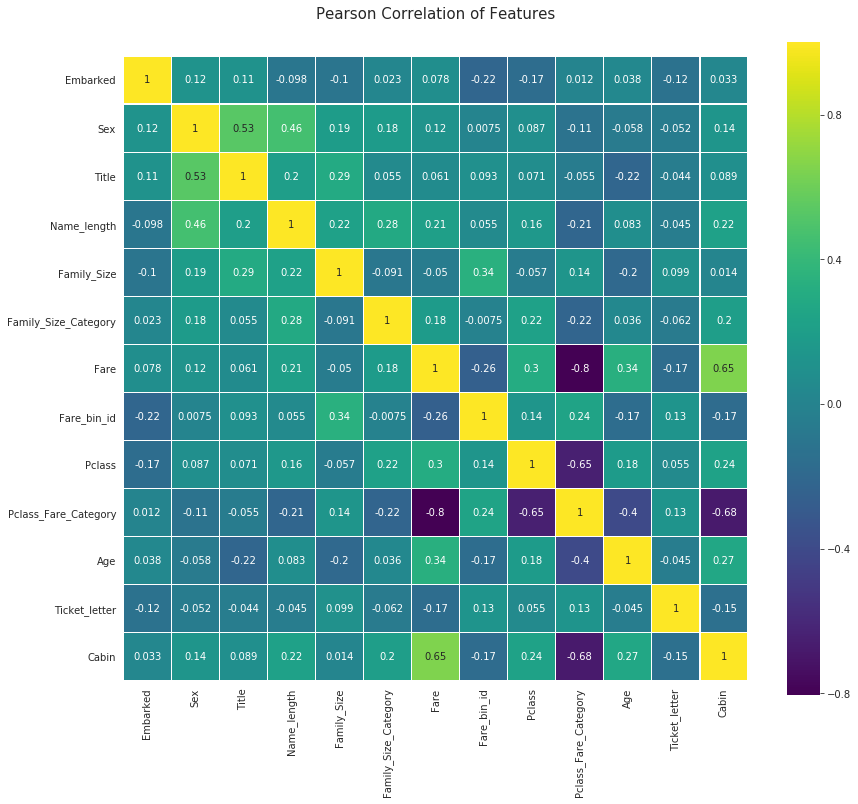

In [84]:
plt.clf()
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(
    Correlation.astype(float).corr()
    , linewidths=0.1
    , vmax=1.0
    , square=True
    , cmap=colormap
    , linecolor='white'
    , annot=True)
plt.show()

### 特征之间的数据分布图

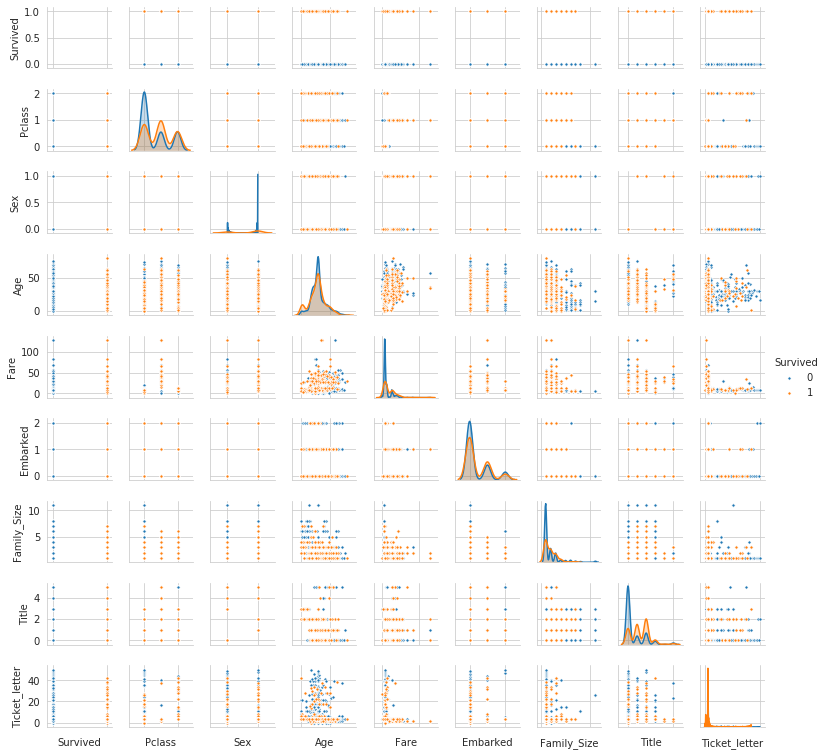

In [85]:
g = sns.pairplot(
    combined_train_test[[
        u'Survived'
        , u'Pclass'
        , u'Sex'
        , u'Age'
        , u'Fare'
        , u'Embarked'
        , u'Family_Size'
        , u'Title'
        , u'Ticket_letter'
    ]]
    , hue='Survived'
    #, palette = 'seismic'
    , size=1.2
    , diag_kind = 'kde'
    , diag_kws=dict(shade=True)
    , plot_kws=dict(s=10)
)
g.set(xticklabels=[])

输入模型前的一些处理：

#### 1. 一些数据的正则化

这里我们将Age和fare进行正则化：

In [86]:
scale_age_fare = preprocessing.StandardScaler().fit(combined_train_test[[
    'Age'
    ,'Fare'
    , 'Name_length'
]])
combined_train_test[[
    'Age'
    ,'Fare'
    , 'Name_length'
]] = scale_age_fare.transform(combined_train_test[[
    'Age'
    ,'Fare'
    , 'Name_length']])

#### 2. 弃掉无用特征

对于上面的特征工程中，我们从一些原始的特征中提取出了很多要融合到模型中的特征，但是我们需要剔除那些原本的我们用不到的或者非数值特征。
首先对我们的数据先进行一下备份，以便后期的再次分析：

In [87]:
combined_data_backup = combined_train_test
combined_train_test.drop([
    'PassengerId'
    , 'Embarked'
    , 'Sex'
    , 'Name'
    , 'Title'
    , 'Fare_bin_id'
    , 'Pclass_Fare_Category'
    , 'Parch'
    , 'SibSp'
    , 'Family_Size_Category'
    , 'Ticket'
],axis=1,inplace=True)

#### 3. 将训练数据和测试数据分开：

In [88]:
combined_train_test.shape

(1309, 36)

In [89]:
train_data = combined_train_test[:891]
test_data = combined_train_test[891:]

titanic_train_data_X = train_data.drop(['Survived'],axis=1)
titanic_train_data_Y = train_data['Survived']
titanic_test_data_X = test_data.drop(['Survived'],axis=1)

(891, 35)

## 6. 模型融合及测试

模型融合的过程需要分几步来进行。

### 6.1 利用不同的模型来对特征进行筛选，选出较为重要的特征：

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

def get_top_n_features(titanic_train_data_X, titanic_train_data_Y, top_n_features):

    # random forest
    rf_est = RandomForestClassifier(random_state=0)
    rf_param_grid = {'n_estimators': [500], 'min_samples_split': [2, 3], 'max_depth': [20]}
    rf_grid = model_selection.GridSearchCV(rf_est, rf_param_grid, n_jobs=25, cv=10, verbose=1)
    rf_grid.fit(titanic_train_data_X, titanic_train_data_Y)
    print('Top N Features Best RF Params:' + str(rf_grid.best_params_))
    print('Top N Features Best RF Score:' + str(rf_grid.best_score_))
    print('Top N Features RF Train Score:' + str(rf_grid.score(titanic_train_data_X, titanic_train_data_Y)))
    feature_imp_sorted_rf = pd.DataFrame({'feature': list(titanic_train_data_X),
                                          'importance': rf_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_rf = feature_imp_sorted_rf.head(top_n_features)['feature']
    print('Sample 10 Features from RF Classifier')
    print(str(features_top_n_rf[:10]))

    # AdaBoost
    ada_est =AdaBoostClassifier(random_state=0)
    ada_param_grid = {'n_estimators': [500], 'learning_rate': [0.01, 0.1]}
    ada_grid = model_selection.GridSearchCV(ada_est, ada_param_grid, n_jobs=25, cv=10, verbose=1)
    ada_grid.fit(titanic_train_data_X, titanic_train_data_Y)
    print('Top N Features Best Ada Params:' + str(ada_grid.best_params_))
    print('Top N Features Best Ada Score:' + str(ada_grid.best_score_))
    print('Top N Features Ada Train Score:' + str(ada_grid.score(titanic_train_data_X, titanic_train_data_Y)))
    feature_imp_sorted_ada = pd.DataFrame({'feature': list(titanic_train_data_X),
                                           'importance': ada_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_ada = feature_imp_sorted_ada.head(top_n_features)['feature']
    print('Sample 10 Feature from Ada Classifier:')
    print(str(features_top_n_ada[:10]))

    # ExtraTree
    et_est = ExtraTreesClassifier(random_state=0)
    et_param_grid = {'n_estimators': [500], 'min_samples_split': [3, 4], 'max_depth': [20]}
    et_grid = model_selection.GridSearchCV(et_est, et_param_grid, n_jobs=25, cv=10, verbose=1)
    et_grid.fit(titanic_train_data_X, titanic_train_data_Y)
    print('Top N Features Best ET Params:' + str(et_grid.best_params_))
    print('Top N Features Best ET Score:' + str(et_grid.best_score_))
    print('Top N Features ET Train Score:' + str(et_grid.score(titanic_train_data_X, titanic_train_data_Y)))
    feature_imp_sorted_et = pd.DataFrame({'feature': list(titanic_train_data_X),
                                          'importance': et_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_et = feature_imp_sorted_et.head(top_n_features)['feature']
    print('Sample 10 Features from ET Classifier:')
    print(str(features_top_n_et[:10]))
    
    # GradientBoosting
    gb_est =GradientBoostingClassifier(random_state=0)
    gb_param_grid = {'n_estimators': [500], 'learning_rate': [0.01, 0.1], 'max_depth': [20]}
    gb_grid = model_selection.GridSearchCV(gb_est, gb_param_grid, n_jobs=25, cv=10, verbose=1)
    gb_grid.fit(titanic_train_data_X, titanic_train_data_Y)
    print('Top N Features Best GB Params:' + str(gb_grid.best_params_))
    print('Top N Features Best GB Score:' + str(gb_grid.best_score_))
    print('Top N Features GB Train Score:' + str(gb_grid.score(titanic_train_data_X, titanic_train_data_Y)))
    feature_imp_sorted_gb = pd.DataFrame({'feature': list(titanic_train_data_X),
                                           'importance': gb_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_gb = feature_imp_sorted_gb.head(top_n_features)['feature']
    print('Sample 10 Feature from GB Classifier:')
    print(str(features_top_n_gb[:10]))
    
    # DecisionTree
    dt_est = DecisionTreeClassifier(random_state=0)
    dt_param_grid = {'min_samples_split': [2, 4], 'max_depth': [20]}
    dt_grid = model_selection.GridSearchCV(dt_est, dt_param_grid, n_jobs=25, cv=10, verbose=1)
    dt_grid.fit(titanic_train_data_X, titanic_train_data_Y)
    print('Top N Features Best DT Params:' + str(dt_grid.best_params_))
    print('Top N Features Best DT Score:' + str(dt_grid.best_score_))
    print('Top N Features DT Train Score:' + str(dt_grid.score(titanic_train_data_X, titanic_train_data_Y)))
    feature_imp_sorted_dt = pd.DataFrame({'feature': list(titanic_train_data_X),
                                          'importance': dt_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_dt = feature_imp_sorted_dt.head(top_n_features)['feature']
    print('Sample 10 Features from DT Classifier:')
    print(str(features_top_n_dt[:10]))
    
    # merge the three models
    features_top_n = pd.concat([features_top_n_rf, features_top_n_ada, features_top_n_et, features_top_n_gb, features_top_n_dt], 
                               ignore_index=True).drop_duplicates()
    
    features_importance = pd.concat([feature_imp_sorted_rf, feature_imp_sorted_ada, feature_imp_sorted_et, 
                                   feature_imp_sorted_gb, feature_imp_sorted_dt],ignore_index=True)
    
    return features_top_n , features_importance

### 6.2 依据我们筛选出的特征构建训练集和测试集

但如果在进行特征工程的过程中，产生了大量的特征，而特征与特征之间会存在一定的相关性。太多的特征一方面会影响模型训练的速度，另一方面也可能会使得模型过拟合。所以在特征太多的情况下，我们可以利用不同的模型对特征进行筛选，选取出我们想要的前n个特征。

In [91]:
feature_to_pick = 30
feature_top_n, feature_importance = get_top_n_features(titanic_train_data_X, titanic_train_data_Y, feature_to_pick)
titanic_train_data_X = pd.DataFrame(titanic_train_data_X[feature_top_n])
titanic_test_data_X = pd.DataFrame(titanic_test_data_X[feature_top_n])

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done  13 out of  20 | elapsed:    5.4s remaining:    2.9s
[Parallel(n_jobs=25)]: Done  20 out of  20 | elapsed:    6.4s finished


Top N Features Best RF Params:{'max_depth': 20, 'min_samples_split': 3, 'n_estimators': 500}
Top N Features Best RF Score:0.8294051627384961
Top N Features RF Train Score:0.978675645342312
Sample 10 Features from RF Classifier
0               Age
21      Name_length
2              Fare
15          Title_0
7             Sex_0
9           Title_0
33      Family_Size
8             Sex_1
34    Ticket_letter
3            Pclass
Name: feature, dtype: object
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done  13 out of  20 | elapsed:    2.5s remaining:    1.3s
[Parallel(n_jobs=25)]: Done  20 out of  20 | elapsed:    3.0s finished


Top N Features Best Ada Params:{'learning_rate': 0.01, 'n_estimators': 500}
Top N Features Best Ada Score:0.8159371492704826
Top N Features Ada Train Score:0.8204264870931538
Sample 10 Feature from Ada Classifier:
33    Family_Size
9         Title_0
2            Fare
15        Title_0
7           Sex_0
3          Pclass
1           Cabin
8           Sex_1
21    Name_length
0             Age
Name: feature, dtype: object
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done  13 out of  20 | elapsed:    1.9s remaining:    1.0s
[Parallel(n_jobs=25)]: Done  20 out of  20 | elapsed:    2.2s finished


Top N Features Best ET Params:{'max_depth': 20, 'min_samples_split': 4, 'n_estimators': 500}
Top N Features Best ET Score:0.8181818181818182
Top N Features ET Train Score:0.9674523007856342
Sample 10 Features from ET Classifier:
15          Title_0
9           Title_0
21      Name_length
0               Age
7             Sex_0
2              Fare
33      Family_Size
8             Sex_1
34    Ticket_letter
1             Cabin
Name: feature, dtype: object
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done  13 out of  20 | elapsed:   11.5s remaining:    6.2s
[Parallel(n_jobs=25)]: Done  20 out of  20 | elapsed:   11.9s finished


Top N Features Best GB Params:{'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 500}
Top N Features Best GB Score:0.7878787878787878
Top N Features GB Train Score:0.9966329966329966
Sample 10 Feature from GB Classifier:
15          Title_0
0               Age
2              Fare
21      Name_length
9           Title_0
33      Family_Size
32         Pclass_5
14          Title_5
3            Pclass
34    Ticket_letter
Name: feature, dtype: object
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Top N Features Best DT Params:{'max_depth': 20, 'min_samples_split': 4}
Top N Features Best DT Score:0.7845117845117845
Top N Features DT Train Score:0.9595959595959596
Sample 10 Features from DT Classifier:
9           Title_0
0               Age
2              Fare
21      Name_length
33      Family_Size
14          Title_5
32         Pclass_5
3            Pclass
34    Ticket_letter
1             Cabin
Name: feature, dtype: object


[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=25)]: Done  20 out of  20 | elapsed:    0.1s finished


用视图可视化不同算法筛选的特征排序：

# 这里错了啊

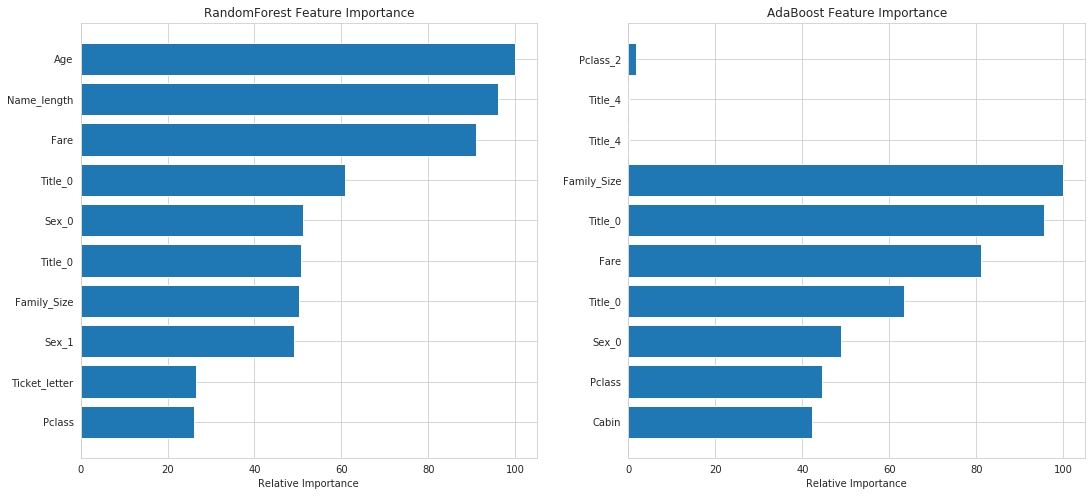

In [92]:
rf_feature_imp = feature_importance[:10]
Ada_feature_imp = feature_importance[32:32+10].reset_index(drop=True)

# make importances relative to max importance
rf_feature_importance = 100.0 * (rf_feature_imp['importance'] / rf_feature_imp['importance'].max())
Ada_feature_importance = 100.0 * (Ada_feature_imp['importance'] / Ada_feature_imp['importance'].max())

# Get the indexes of all features over the importance threshold
rf_important_idx = np.where(rf_feature_importance)[0]
Ada_important_idx = np.where(Ada_feature_importance)[0]

# Adapted from Gradient Boosting regression
pos = np.arange(rf_important_idx.shape[0]) + .5

plt.figure(1, figsize = (18, 8))

plt.subplot(121)
plt.barh(pos, rf_feature_importance[rf_important_idx][::-1])
plt.yticks(pos, rf_feature_imp['feature'][::-1])
plt.xlabel('Relative Importance')
plt.title('RandomForest Feature Importance')

plt.subplot(122)
plt.barh(pos, Ada_feature_importance[Ada_important_idx][::-1])
plt.yticks(pos, Ada_feature_imp['feature'][::-1])
plt.xlabel('Relative Importance')
plt.title('AdaBoost Feature Importance')

plt.show()

### 6.3 模型融合（Model Ensemble）

常见的模型融合方法有：Bagging、Boosting、Stacking、Blending。

#### 3-1: Bagging

Bagging 将多个模型，也就是多个基学习器的预测结果进行简单的加权平均或者投票。它的好处是可以并行地训练基学习器。Random Forest就用到了Bagging的思想。

#### 3-2: Boosting

Boosting 的思想有点像知错能改，每个基学习器是在上一个基学习器学习的基础上，对上一个基学习器的错误进行弥补。我们将会用到的 AdaBoost，Gradient Boost 就用到了这种思想。

#### 3-3: Stacking

Stacking是用新的次学习器去学习如何组合上一层的基学习器。如果把 Bagging 看作是多个基分类器的线性组合，那么Stacking就是多个基分类器的非线性组合。Stacking可以将学习器一层一层地堆砌起来，形成一个网状的结构。

相比来说Stacking的融合框架相对前面的二者来说在精度上确实有一定的提升，所以在下面的模型融合上，我们也使用Stacking方法。

#### 3-4: Blending

Blending 和 Stacking 很相似，但同时它可以防止信息泄露的问题。

Stacking框架融合:

这里我们使用了两层的模型融合，Level 1使用了：RandomForest、AdaBoost、ExtraTrees、GBDT、DecisionTree、KNN、SVM ，一共7个模型，Level 2使用了XGBoost使用第一层预测的结果作为特征对最终的结果进行预测。

Level 1：

Stacking框架是堆叠使用基础分类器的预测作为对二级模型的训练的输入。 然而，我们不能简单地在全部训练数据上训练基本模型，产生预测，输出用于第二层的训练。如果我们在Train Data上训练，然后在Train Data上预测，就会造成标签泄露。为了避免标签泄露，我们需要对每个基学习器使用K-fold，将K个模型对Valid Set的预测结果拼起来，作为下一层学习器的输入。

所以这里我们建立输出K-fold预测的方法：

In [93]:
from sklearn.model_selection import KFold

# Some useful parameters which will come in handy later on
ntrain = titanic_train_data_X.shape[0]
ntest = titanic_test_data_X.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 7 # set folds for out-of-fold prediction
kf = KFold(n_splits = NFOLDS, random_state=SEED, shuffle=False)

def get_out_fold(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.fit(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

构建不同的基学习器，这里我们使用了RandomForest、AdaBoost、ExtraTrees、GBDT、DecisionTree、KNN、SVM 七个基学习器：（这里的模型可以使用如上面的GridSearch方法对模型的超参数进行搜索选择）

In [94]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

rf = RandomForestClassifier(n_estimators=500, warm_start=True, max_features='sqrt',max_depth=6, 
                            min_samples_split=3, min_samples_leaf=2, n_jobs=-1, verbose=0)

ada = AdaBoostClassifier(n_estimators=500, learning_rate=0.1)

et = ExtraTreesClassifier(n_estimators=500, n_jobs=-1, max_depth=8, min_samples_leaf=2, verbose=0)

gb = GradientBoostingClassifier(n_estimators=500, learning_rate=0.008, min_samples_split=3, min_samples_leaf=2, max_depth=5, verbose=0)

dt = DecisionTreeClassifier(max_depth=8)

knn = KNeighborsClassifier(n_neighbors = 2)

svm = SVC(kernel='linear', C=0.025)

将pandas转换为arrays：

In [98]:
# Create Numpy arrays of train, test and target (Survived) dataframes to feed into our models
x_train = titanic_train_data_X.values # Creates an array of the train data
x_test = titanic_test_data_X.values # Creats an array of the test data
y_train = titanic_train_data_Y.values

# Create our OOF train and test predictions. These base results will be used as new features
rf_oof_train, rf_oof_test = get_out_fold(rf, x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_out_fold(ada, x_train, y_train, x_test) # AdaBoost 
et_oof_train, et_oof_test = get_out_fold(et, x_train, y_train, x_test) # Extra Trees
gb_oof_train, gb_oof_test = get_out_fold(gb, x_train, y_train, x_test) # Gradient Boost
dt_oof_train, dt_oof_test = get_out_fold(dt, x_train, y_train, x_test) # Decision Tree
knn_oof_train, knn_oof_test = get_out_fold(knn, x_train, y_train, x_test) # KNeighbors
svm_oof_train, svm_oof_test = get_out_fold(svm, x_train, y_train, x_test) # Support Vector

print("Training is complete")

Training is complete


### 6.4 预测并生成提交文件

Level 2：

我们利用XGBoost，使用第一层预测的结果作为特征对最终的结果进行预测。

In [99]:
x_train = np.concatenate((rf_oof_train, ada_oof_train, et_oof_train, gb_oof_train, dt_oof_train, knn_oof_train, svm_oof_train), axis=1)
x_test = np.concatenate((rf_oof_test, ada_oof_test, et_oof_test, gb_oof_test, dt_oof_test, knn_oof_test, svm_oof_test), axis=1)

from xgboost import XGBClassifier

gbm = XGBClassifier( n_estimators= 2000, max_depth= 4, min_child_weight= 2, gamma=0.9, subsample=0.8, 
                     colsample_bytree=0.8, objective= 'binary:logistic', nthread= -1, scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

StackingSubmission = pd.DataFrame({'PassengerId': PassengerId, 'Survived': predictions})
StackingSubmission.to_csv('StackingSubmission.csv',index=False,sep=',')

ModuleNotFoundError: No module named 'xgboost'